Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py", line 196, in process
    func(*args, **kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\animation.py", line 1467, in _stop
    self.event_source.remove_callback(self._loop_delay)
AttributeError: 'NoneType' object has no attribute 'remove_callback'


<IPython.core.display.Javascript object>


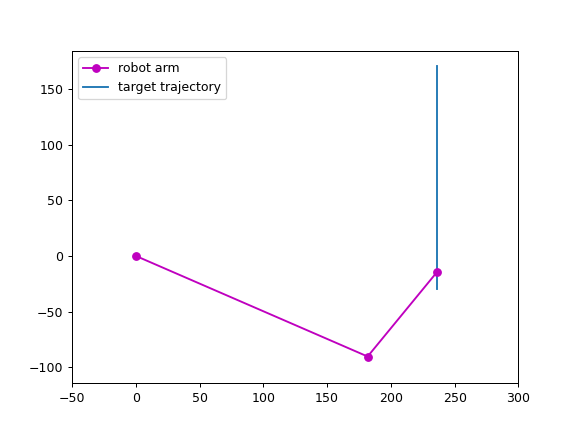

done


In [2]:
%matplotlib nbagg

import numpy as np
import matplotlib.pyplot as plt
from math import *
import matplotlib.animation as animation

# 逆運動学を解いて各関節角度を出力
def calc_ik(goal_pos, l1, l2):
    x_ref = goal_pos[0][0]
    y_ref = goal_pos[1][0]
    
    phi2 = acos((x_ref**2 + y_ref**2 - l1**2 - l2**2)/(2*l1*l2))
    phi1 = atan2(-l2*sin(phi2)*x_ref + (l1+l2*cos(phi2))*y_ref,(l1+l2*cos(phi2))*x_ref + l2*sin(phi2)*y_ref)
    
    return phi1,phi2

# 直線軌道での所望の座標を出力 start, endはnumpy_array
def calc_line_coodinate(start, end, cur_t, req_t):
    s = 6*(cur_t/req_t)**5 - 15*(cur_t/req_t)**4 + 10*(cur_t/req_t)**3
    goal_pos = start*(1-s) + end*s
    
    return goal_pos 

# 追従させる軌道 直線 端点の2つの座標を与える.  binは時間の分割数. 各時刻における所望の座標のリストを返す(indexは分割数個)
def calc_line_coodinate_bytime(start, end, req_t):
    cur_t = 0
    x_refs = []
    y_refs = []
    while(cur_t < req_t):
        s = 6*(cur_t/req_t)**5 - 15*(cur_t/req_t)**4 + 10*(cur_t/req_t)**3
        x_ref = start[0]*(1-s) + end[0]*s
        y_ref = start[1]*(1-s) + end[1]*s
        x_refs.append(x_ref)
        y_refs.append(y_ref)
        cur_t += 1
    
    return x_refs, y_refs

# 順運動学で第一関節の位置を計算
def calc_cur_first_pos(l1,phi1):
    x = l1*cos(phi1)
    y = l1*sin(phi1)
    cur_first_pos = [x,y]

    return cur_first_pos

# 順運動学で第二関節の位置を計算
def calc_cur_second_pos(l1,l2,phi1,phi2):
    x = l1*cos(phi1) + l2*cos(phi1+phi2)
    y = l1*sin(phi1) + l2*sin(phi1+phi2)
    cur_second_pos = np.array([[x],
                               [y]])

    return cur_second_pos

# params
phi1 = 0.5
phi2 = 0.4

#簡単のためとりあえず全て1
l1 = 83 + 120
l2 = 93.5

# 初期位置, 終了位置
start = calc_cur_second_pos(l1,l2,phi1,phi2)
end = np.array([[start[0][0]],
                [start[1][0] - 200]]
               )

# 処理にかかる時間
req_t = 1000 # ms

ims = []
fig = plt.figure()
flag_legend = True

# iteration
cur_t = 0
x_refs, y_refs = calc_line_coodinate_bytime(start, end, req_t)
while (cur_t < req_t):
    cur_first_pos = calc_cur_first_pos(l1,phi1) # 現在位置
    cur_second_pos = calc_cur_second_pos(l1,l2,phi1,phi2) # 現在位置
    goal_pos = calc_line_coodinate(start, end, cur_t, req_t) # 次の目標座標
    phi1, phi2 = calc_ik(goal_pos, l1, l2) # 目標座標に対して関節角度を計算
    
    # プロット用
    if cur_t %5 == 0:
        im1 = plt.plot([0,cur_first_pos[0],cur_second_pos[0][0]],[0,cur_first_pos[1],cur_second_pos[1][0]],'b-o',label="robot arm",color="m")
        ims.append(im1)
    
    if flag_legend: # 1回のみ凡例を描画
        plt.plot(x_refs, y_refs, label="target trajectory")
        plt.legend()
        plt.xlim(-50,300)
        #plt.axes().set_aspect('equal')
        flag_legend = False
        
    cur_t += 1

ani = animation.ArtistAnimation(fig, ims, interval=10)
ani.save('time_line_compiance_2link.gif', writer='pillow', fps=50)
fig.show()

print("done")